In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
RelTimeDF.shape

(771, 3)

In [4]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [5]:
del RelTimeCCDF["Unnamed: 0"]

In [6]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [7]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [8]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [9]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

y 103
n 596


In [10]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

succeeding (quasi)polity 364
relationship to preceding (quasi)polity 335


In [11]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [12]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [13]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

vassalage 1
contination 1
suspected unknown 2
cultural assimilation 25
continuation 7
continunity 4
population migration 13
indigenous revolt 1
Continuation 1
elite migration 40
Continuity 9
replacement 1
continuity 228
not applicable 2


In [14]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [16]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [17]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Susiana,Cambodian Basin,Kachi Plain,Kansai,Middle Yellow River Valley,Sogdiana,Ghanaian Coast,Iceland,Latium,Yemeni Coastal Plain,Deccan,Cuzco,Orkhon Valley,Central Java,Konya Plain,Niger Inland Delta,Upper Egypt,Paris Basin
0,T0,-3700,300,-2500,400,-1800,-500,1800,1300,-700,400,-300,1400,500,800,-2000,1000,-3100,-200


In [18]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [19]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

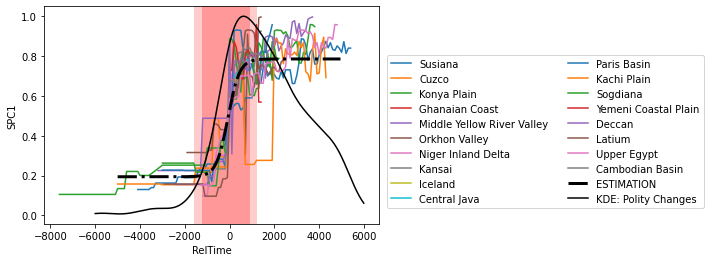

In [21]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [22]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [23]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [24]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

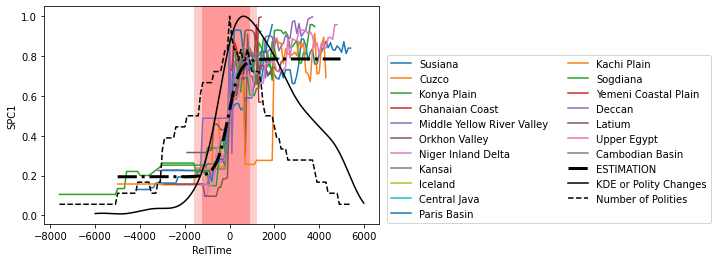

In [25]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [26]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [27]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [28]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [29]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [30]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs          NGA  RelTime
699  Susiana   1617.0
708  Susiana   2300.0
710  Susiana   2500.0
713  Susiana   2600.0
726  Susiana   3740.0
744  Susiana   4762.0
745  Susiana   4762.0
746  Susiana   4857.0
747  Susiana   4857.0
754  Susiana   5039.0
756  Susiana   5039.0
757  Susiana   5201.0
764  Susiana   5422.0
765  Susiana   5625.0
-inf 1617.0
        NGA  RelTime      SPC1
0   Susiana    -4100  0.129737
1   Susiana    -4000  0.129737
2   Susiana    -3900  0.129737
3   Susiana    -3800  0.129737
4   Susiana    -3700  0.129737
5   Susiana    -3600  0.129737
6   Susiana    -3500  0.139350
7   Susiana    -3400  0.139350
8   Susiana    -3300  0.162183
9   Susiana    -3200  0.162183
10  Susiana    -3100  0.162183
11  Susiana    -3000  0.162183
12  Susiana    -2900  0.162183
13  Susiana    -2800  0.162183
14  Susiana    -2700  0.162183
15  Susiana    -2600  0.162183
16  Susiana    -2500  0.162183
17  Susiana    -2400  0.162183
18  Susiana    -2300  0.192817
19  Susiana    -2200  0.192817
20 

BPs                NGA  RelTime
488  Orkhon Valley   -250.0
496  Orkhon Valley    244.0
499  Orkhon Valley    340.0
503  Orkhon Valley    868.0
504  Orkhon Valley    868.0
509  Orkhon Valley   1257.0
-250.0 244.0
BPs                NGA  RelTime
488  Orkhon Valley   -250.0
496  Orkhon Valley    244.0
499  Orkhon Valley    340.0
503  Orkhon Valley    868.0
504  Orkhon Valley    868.0
509  Orkhon Valley   1257.0
-250.0 244.0
BPs                     NGA  RelTime
457  Niger Inland Delta   -951.0
476  Niger Inland Delta    712.0
-951.0 712.0
                    NGA  RelTime      SPC1
642  Niger Inland Delta     -900  0.201994
643  Niger Inland Delta     -800  0.201994
644  Niger Inland Delta     -700  0.201994
645  Niger Inland Delta     -600  0.302212
646  Niger Inland Delta     -500  0.302212
647  Niger Inland Delta     -400  0.302212
648  Niger Inland Delta     -300  0.302212
649  Niger Inland Delta     -200  0.302212
650  Niger Inland Delta     -100  0.378760
651  Niger Inland Delta     

BPs              NGA  RelTime
784  Upper Egypt   2353.0
788  Upper Egypt   2575.0
791  Upper Egypt   2758.0
797  Upper Egypt   3384.0
819  Upper Egypt   4271.0
-inf 2353.0
                 NGA  RelTime      SPC1
166  Cambodian Basin        0  0.673646
167  Cambodian Basin      100  0.673646
168  Cambodian Basin      200  0.673646
169  Cambodian Basin      300  0.664762
170  Cambodian Basin      400  0.753940
171  Cambodian Basin      500  0.783000
172  Cambodian Basin      600  0.844609
173  Cambodian Basin      700  0.828656
174  Cambodian Basin      800  0.840909
175  Cambodian Basin      900  0.840909
176  Cambodian Basin     1000  0.812885
177  Cambodian Basin     1100  0.812885
178  Cambodian Basin     1200  0.810691
179  Cambodian Basin     1300  0.806051
180  Cambodian Basin     1400  0.806733
181  Cambodian Basin     1500  0.797299


In [31]:
Cutout_DF, Cutout_CCDF


(                 NGA RelTime      SPC1
 0            Susiana   -4100  0.129737
 1            Susiana   -4000  0.129737
 2            Susiana   -3900  0.129737
 3            Susiana   -3800  0.129737
 4            Susiana   -3700  0.129737
 ..               ...     ...       ...
 177  Cambodian Basin    1100  0.812885
 178  Cambodian Basin    1200  0.810691
 179  Cambodian Basin    1300  0.806051
 180  Cambodian Basin    1400  0.806733
 181  Cambodian Basin    1500  0.797299
 
 [365 rows x 3 columns],
                  NGA RelTime      SPC1    PolPop   PolTerr    CapPop  \
 675          Susiana   -4100  0.129737  1.597045  1.844231  2.591618   
 676          Susiana   -4000  0.129737  1.597045  1.844231  2.591618   
 677          Susiana   -3900  0.129737  1.597045  1.844231  2.591618   
 678          Susiana   -3800  0.129737  1.597045  1.844231  2.591618   
 679          Susiana   -3700  0.129737  1.597045  1.844231  2.591618   
 ..               ...     ...       ...       ...      

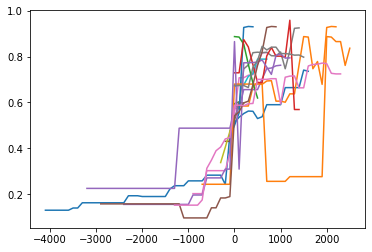

In [32]:
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

### Dan's Questions

Do large NGAs reach the SPC1 threshold again after a decline?

In [33]:
DF_Second = Cutout_DF.loc[Cutout_DF["RelTime"]>-1]
DF_Second.loc[DF_Second["SPC1"]< 0.49] # this is the SPC_Break from the other notebook

,NGA,RelTime,SPC1
261,Kachi Plain,700,0.255631
262,Kachi Plain,800,0.255631
263,Kachi Plain,900,0.255631
264,Kachi Plain,1000,0.255631
265,Kachi Plain,1100,0.255631
266,Kachi Plain,1200,0.276092
267,Kachi Plain,1300,0.276092
268,Kachi Plain,1400,0.276092
269,Kachi Plain,1500,0.276092
270,Kachi Plain,1600,0.276092


So indeed, the Orkhon Valley experiences a decline in SPC1 below the threshold after a discontinuous polity change!

In [34]:
# analyse this further
RelTimeDF.loc[RelTimeDF["NGA"] == "Orkhon Valley"]

,NGA,RelTime,SPC1
485,Orkhon Valley,-1900,0.315541
486,Orkhon Valley,-1800,0.315541
487,Orkhon Valley,-1700,0.315541
488,Orkhon Valley,-1600,0.315541
489,Orkhon Valley,-1500,0.315541
490,Orkhon Valley,-1400,0.315541
491,Orkhon Valley,-1300,0.315541
492,Orkhon Valley,-1200,0.315541
493,Orkhon Valley,-1100,0.315541
494,Orkhon Valley,-1000,0.315541


# Redo the RelTime Analysis with this Data?

## Fitting

In [35]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526190e-01  2.04512959e-01  4.20835763e+01 -2.17749682e-02]


In [36]:
# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749265e+01, -1.54321380e-02])

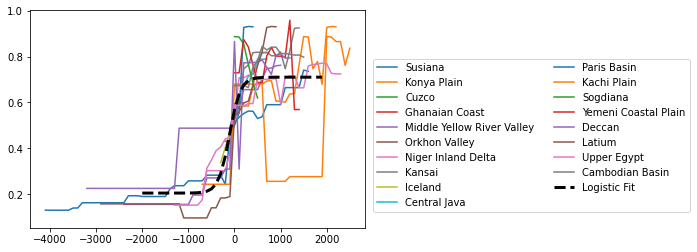

In [37]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [38]:
L = len(Cutout_DF["RelTime"].to_numpy())
def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [39]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    

In [40]:
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

0.7486773825843114 0.751432224951792 0.031332293685627025


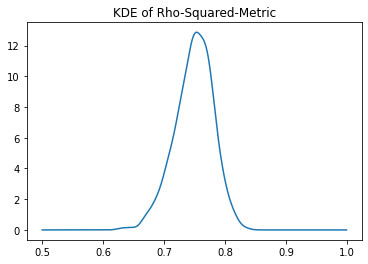

In [41]:
plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [42]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.4631903176641595 0.21122717793430396 44.239244461975815 -0.026540672212120538
-----------------
0.45824105061675613 0.2431645915353591 32.172505576385355 -0.025463767038574864
-----------------
0.5243482561049833 0.1897223425112069 21.01925530757572 -0.03238981257458244
-----------------
0.6259591749586226 0.16552603236924557 28.733372852500544 -0.009080210175116336
-----------------
0.4573273367267595 0.21382378022376408 56.995973750539534 -0.022667726535382512
-----------------
0.5663285646999483 0.1832033977431872 20.72955427110531 -0.025719883417361096
-----------------
0.6350735787770825 0.1557092631803588 36.14194618242383 -0.015066991390237733
-----------------
0.4756175584942528 0.1962813761678612 114.97036766178596 -0.016811335143670655
-----------------
0.6021757054513331 0.1901912957900717 26.886735356381916 -0.007314448360014916
-----------------
0.6062081112453099 0.17225881211170718 37.14233855138537 -0.0160946752772036
-----------------
0.48773745294677623 0.2001341990

0.5812311580054598 0.1735986486868988 28.001360077298553 -0.012014499563898443
-----------------
0.578860654005804 0.17491225191079648 25.45659694732178 -0.02647790456202931
-----------------
0.593091268629861 0.16768487567655518 32.71345894387006 -0.02010590993065886
-----------------
0.5973996892018872 0.17570431412725604 33.26963414531315 -0.013983422156860761
-----------------
0.4712639820292654 0.24214448633096833 69.74559577729461 -0.016466209755347263
-----------------
0.5070074287497104 0.18909206570844114 56.58210394855391 -0.016256611687101
-----------------
0.5978308099777269 0.16135233653959954 29.32949802082045 -0.024343752507498727
-----------------
0.5056687793656333 0.1987547424537376 34.455174907777696 -0.027888435970887734
-----------------
0.5031556017610826 0.20321290269371933 100.71662192804803 -0.015721437332739067
-----------------
0.4433232790031486 0.21758132383008508 176.49268723378282 -0.016241746799749372
-----------------
0.5511022550912272 0.19010367560444

0.4840484459763672 0.20269352317078132 45.86409228756358 -0.02017889254372734
-----------------
0.5328147684469259 0.25340964527114657 18.501954176025826 -0.02666033224995445
-----------------
0.5183232700217608 0.1887941098050793 40.19076768804637 -0.018004444407109618
-----------------
0.560461471231418 0.20047004842003624 24.296323682236533 -0.020104218272244314
-----------------
0.4372210788352146 0.20663667293942262 99.23637800199235 -0.018228565403431766
-----------------
0.38085275209085895 0.27665043704206677 782.7534645929281 -0.01871625822027161
-----------------
0.5009452759657965 0.21279036281073221 50.49998929627521 -0.018413240765920335
-----------------
0.48902745374078344 0.22733670138306847 34.681279356428995 -0.0278461953185126
-----------------
0.5447645722267433 0.2178789756141238 18.45511491557218 -0.025606638707064033
-----------------
0.5144444686608807 0.19569799886216835 28.5213369418305 -0.018068646380129165
-----------------
0.5417880916658449 0.1866687784414

0.5301402146801719 0.17179572213991368 30.149239149709647 -0.037367887084575356
-----------------
0.48662324379333666 0.20003625235485983 28.697772524336568 -0.027946436018403194
-----------------
0.5145628161482311 0.19288495370769146 27.66368356435165 -0.026270323182689147
-----------------
0.5433234633285264 0.18322441177479845 51.93720919703232 -0.014759920824772512
-----------------
0.5454075903596365 0.1950262296559098 40.40506042938987 -0.023145219035545603
-----------------
0.41337805964585567 0.22100104921584512 58.82683033986619 -0.02457737928243178
-----------------
0.4528868323184838 0.19936101315291296 906.988540980779 -0.01902077983175806
-----------------
0.5494158375695783 0.1830145330938765 39.46830029445818 -0.018242339322607163
-----------------
0.5446607454759674 0.16794688749288528 53.74872419884065 -0.02178659531906408
-----------------
0.518652130688155 0.19797311406172766 33.047219422731324 -0.01849147933463546
-----------------


C:\Users\Tobias\AppData\Local\Temp/ipykernel_6836/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.6300431456431116 0.20177143690812824 11.2223773561245 -0.04713775896375922
-----------------
0.5776209440373258 0.16857383183883234 33.653008037654324 -0.02341501483385766
-----------------
0.4726940566531306 0.18550530971290174 64.84092764661553 -0.02193806483014639
-----------------
0.45860781117639116 0.22603172312819625 48.717929314239065 -0.023656593899856443
-----------------
0.5123511297230647 0.1827909387606141 55.91890041564999 -0.02180572342244934
-----------------
0.4507202728778283 0.22399925267394974 31.909754218776722 -0.03012136735625074
-----------------
0.5668103982446613 0.20000279444651653 33.44481000067001 -0.017553866512527827
-----------------
0.4637986842525771 0.25002822584466344 48.29989560845895 -0.015123230938066497
-----------------
0.5276334551958486 0.1860540885314154 45.51473536608193 -0.025945181721682527
-----------------
0.5609623642214676 0.164974336858297 68.76918828465747 -0.013316180178753266
-----------------
0.551732819931405 0.1665026791051211

0.4986234942165253 0.2124884464895581 33.148106911253066 -0.01993787415330981
-----------------
0.5449299903441646 0.16483219515074926 44.20586898375127 -0.016543294575700387
-----------------
0.5891523448106502 0.1671175814764116 42.19698365839379 -0.019684714489979424
-----------------
0.44948975514154615 0.2018367924077502 46.697455091211445 -0.023575884230456146
-----------------
0.5345347321589978 0.1920092525413846 36.226631962756045 -0.024280919579328486
-----------------
0.5933559653194421 0.19303818593982977 25.443545248321332 -0.014872247489123091
-----------------
0.6147606049156125 0.16088637063277075 29.461456915056733 -0.01637973900226893
-----------------
0.5712128042556038 0.1963450821065861 30.1039984507386 -0.018045975683057457
-----------------
0.5127666143464155 0.17911618587784542 66.18910178632264 -0.019031252185251667
-----------------
0.5069371099429947 0.20363491919384227 31.08882821079022 -0.027976741662187294
-----------------
0.5575607431456159 0.19235733626

0.5512852251769413 0.16480303836581905 39.145389962710894 -0.017372386261159823
-----------------
0.6060256762982972 0.158084808939117 30.046965160614853 -0.020650795757165125
-----------------
0.44087046865419893 0.2269321119716526 58.246555508450605 -0.02170838301195299
-----------------
0.5799524038520644 0.18449336541731176 28.67127463616965 -0.008003389216094281
-----------------
0.4755014315401858 0.2208950827244991 22.61625875828201 -0.03268242730739683
-----------------
0.45514528008476585 0.1961973565579373 90.42395375264276 -0.0207909943095695
-----------------
0.47837935892612227 0.18245161142328542 37.30823771813877 -0.029779985240812597
-----------------
0.47145628806171125 0.23297293228201704 46.00580023244297 -0.019924633134923198
-----------------
0.5714596759300841 0.20602160200507608 34.76411292232123 -0.012887957660343207
-----------------
0.5155153507225632 0.17593876209577924 71.7615895157807 -0.019054973996111883
-----------------
0.5392192358273011 0.217248734864

0.5182701671363793 0.18712937536591054 62.38283523459245 -0.022037580639411677
-----------------
0.5396504349507301 0.18848384352332323 25.59411960182513 -0.02535563705823664
-----------------
0.5722333809436291 0.16752602808621683 26.593604689659486 -0.02317772981465983
-----------------
0.5807100583304474 0.1603439659098977 49.90003402338927 -0.017389893825903262
-----------------
0.42867190712871656 0.2384623200697031 180.14298711245416 -0.014051733643548628
-----------------
0.5066333100935847 0.19786790892447625 61.13397976300124 -0.022633162215014952
-----------------
0.6410351210017775 0.15742901905416154 34.8130140784984 -0.010008980240496559
-----------------
0.5883929291979133 0.16735124948839206 28.665212889171848 -0.011598134707037017
-----------------
0.39906783946157665 0.2487139623676589 310.0664468100843 -0.0164683402161798
-----------------
0.50368206007489 0.19341970675736314 46.01073767693642 -0.024617190596293873
-----------------
0.5104472300906786 0.19406809532478

0.6017035276799773 0.18005627033930502 26.267288272585464 -0.011057463662569333
-----------------
0.5119698276295745 0.20903962444773744 35.90439014563129 -0.01735951845144187
-----------------
0.45951494182612684 0.232554207696609 64.51790143036996 -0.014919556000265925
-----------------
0.5743272117245574 0.17190775693926974 33.34911608734291 -0.014065968493026368
-----------------
0.47716278609225027 0.18854490667587426 69.32925340367032 -0.01902680728793718
-----------------
0.46774078212454223 0.2067510645916377 34.95401056328822 -0.023959498381123844
-----------------
0.5537798942711236 0.17279880814273793 28.702445002252404 -0.02512533838926316
-----------------
0.6117458157349625 0.1642683011630717 28.3436316142362 -0.03410003322477382
-----------------
0.42761865462946397 0.24474853791175147 68.3459836572337 -0.017773295211916014
-----------------
0.557346727340128 0.20738277378612605 28.336998967018953 -0.021359901343828924
-----------------
0.3834671612591484 0.3020731169386

0.5607676063354426 0.20350670444463023 25.5828844429577 -0.02717555511160398
-----------------
0.6134260416898487 0.17752833873039273 31.051920623052165 -0.01087567374900874
-----------------
0.4476177784506914 0.1884114624847054 78.6443502245606 -0.020873341004370403
-----------------
0.5737556820502707 0.19149729550063618 28.34600806932287 -0.018713196849988217
-----------------
0.41534034968199535 0.2403164929300475 73.32071700346224 -0.019037975042555482
-----------------
0.501294329327343 0.1890115776073411 82.77986429372042 -0.01761136233275498
-----------------
0.5804396009958593 0.17758145435383976 56.407437203895746 -0.019025770444443483
-----------------
0.5683818631807929 0.22073679030895252 21.522090067480033 -0.028148918705492892
-----------------
0.562253573718876 0.22083022970124144 20.737545361309973 -0.02335746065765701
-----------------
0.5437014496238116 0.18011189437351718 43.72007548548509 -0.018259394405288856
-----------------
0.4378808765906256 0.228448479186043

0.5473739977329222 0.16902385920161492 20.5022577465652 -0.030239062418364996
-----------------
0.6059849414183502 0.1638504165652411 28.73854965222965 -0.03103866090392994
-----------------
0.6187092439077194 0.20275533904186333 13.035561998270401 -0.018350782120223723
-----------------
0.5895446772956018 0.19260508370923343 26.117847560681756 -0.022425953604100733
-----------------
0.4727660101134456 0.2274429945121734 41.93292182433996 -0.024748017739389876
-----------------
0.5277243464754168 0.16904800495504807 43.725501304596 -0.019596772286405995
-----------------
0.5285868082055762 0.17216559183975028 27.15729737309812 -0.03384171314587318
-----------------
0.5412415073092733 0.1648329014679873 27.820893027854428 -0.035097165471675205
-----------------
0.5721891079783872 0.1943092905835819 24.968395034135405 -0.015654117183261547
-----------------
0.4920259386380794 0.2037799905683758 27.41496222318512 -0.03550251131043318
-----------------
0.5167561111081665 0.2120585376012837

0.6203188965560351 0.16449985050566746 34.74553623911118 -0.018026431075798623
-----------------
0.5342421336493703 0.1887348082128935 45.52450738853932 -0.01582107091973914
-----------------
0.5354457845605253 0.18912269766889195 43.314925789012385 -0.020576715125147815
-----------------
0.4753486813238716 0.18117664506098377 83.87319972096566 -0.01986325725031271
-----------------
0.4965947199223606 0.18074709393516436 70.51494385708038 -0.020656481133738313
-----------------
0.5784825956960647 0.17430073651110448 36.59476992834882 -0.01717221118182514
-----------------
0.4609797406083797 0.19947300282203795 61.357920346336186 -0.022404335479237706
-----------------
0.5311194859419861 0.17670469296041555 41.73809351344434 -0.020376259347974483
-----------------
0.5492818770223316 0.19951303648776206 20.823356599196064 -0.027847939053628454
-----------------
0.48198491368508734 0.22403124008164593 22.00694111045467 -0.03402048557037512
-----------------
0.5154782309570828 0.1827456558

0.5420558133260942 0.23196711184300242 43.93944982278365 -0.010384749175991349
-----------------
0.5076218073733755 0.20550768120450083 44.74517775665359 -0.0233388550832363
-----------------
0.6060056850352666 0.15772695752422913 28.48998116131588 -0.02361679949685428
-----------------
0.5842346615452998 0.1839907785769739 25.405903673322925 -0.014050960612877932
-----------------
0.5513817059081422 0.2095634580893194 17.366064722088993 -0.045051848325583954
-----------------
0.5697490661276513 0.19776320755951152 23.30601164397343 -0.03392484851958519
-----------------
0.4730753754602459 0.2103223155895452 39.31257257779045 -0.025654526080893993
-----------------
0.5988456501434094 0.1645046423884653 36.89086553280252 -0.01496096452935972
-----------------
0.47494420325785686 0.20342820200665238 38.84171322934271 -0.027538466866724235
-----------------
0.5448501911997291 0.21104568592770126 30.601007686170632 -0.023498452919383486
-----------------
0.6026658747115027 0.18865295326257

In [43]:
print(negCcount)

0


In [44]:
Params

,a,b,c,d
0,0.463190,0.211227,44.239244,-0.026541
0,0.458241,0.243165,32.172506,-0.025464
0,0.524348,0.189722,21.019255,-0.032390
0,0.625959,0.165526,28.733373,-0.009080
0,0.457327,0.213824,56.995974,-0.022668
...,...,...,...,...
0,0.421555,0.283872,64.231888,-0.011611
0,0.475487,0.198542,261.587206,-0.017242
0,0.473281,0.222766,49.455154,-0.025308
0,0.545723,0.187062,47.378572,-0.020064


50% centred quantiles 0.47681802921878025 0.5615186828265065
90% centred quantiles 0.4199991825685021 0.6045961950211348


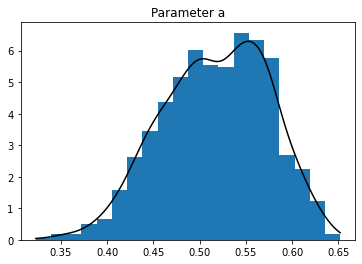

50% centred quantiles 0.18322238168866653 0.21761119630306616
90% centred quantiles 0.16465738930791174 0.2575426330283205


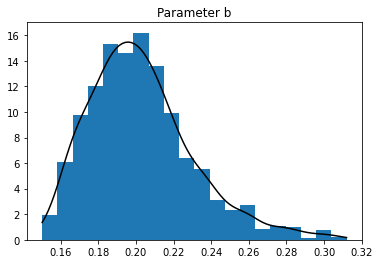

50% centred quantiles 27.838506255150033 57.13367412635092
90% centred quantiles 18.207155625066623 151.7695481102397


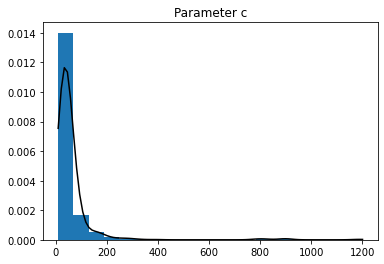

50% centred quantiles -0.0251229014293614 -0.01713918622397892
90% centred quantiles -0.0361720169852984 -0.013043709037098393


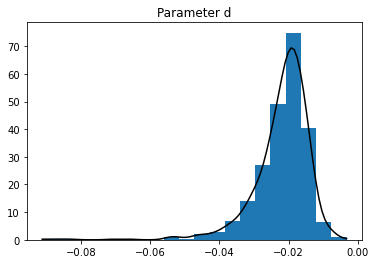

In [45]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [46]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(27.838506255150033, 57.13367412635092)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


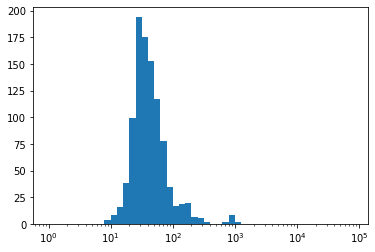

In [47]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [48]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20273399067635736 0.027833325179500698
0.7199847773005715 0.04289364526504272
0.23056731585585805 0.6770911320355288


C:\Users\Tobias\AppData\Local\Temp/ipykernel_6836/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [49]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1301.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [50]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [51]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.5243482561049833 0.1897223425112069 21.01925530757572 -0.03238981257458244     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.17388346e-13])
       r: array([-0.79165431])
  status: 1
 success: True
       x: array([-0.14996174])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.17486029e-11])
       r: array([-0.72246427])
  status: 1
 success: True
       x: array([0.09029095])
-----------------
0.6259591749586226 0.16552603236924557 28.733372852500544 -0.009080210175116336     fjac: array([[-1.]])
     fun: array([5.24580379e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([7.30708105e-10])
       r: array([-1.67465707])
  status: 1
 success: True
       x: array([-0.08406453])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.50465307e-10])
   

C:\Users\Tobias\AppData\Local\Temp/ipykernel_6836/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.566842268268758 0.19532842496817288 40.98478644499983 -0.017787851705546615     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([1.09356968e-14])
       r: array([-1.3544732])
  status: 1
 success: True
       x: array([-0.08400138])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.18252108e-13])
       r: array([-2.96359489])
  status: 1
 success: True
       x: array([0.02451723])
-----------------
0.501788115990119 0.18863011840819682 46.414765470687676 -0.025444267171945412     fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.20479071e-10])
       r: array([-1.78381877])
  status: 1
 success: True
       x: array([-0.07703839])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.10593789e-11])
  

0.5614481244992436 0.19859886723356845 26.853804122353946 -0.018278401132930205     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([6.79645229e-12])
       r: array([-0.80959402])
  status: 1
 success: True
       x: array([-0.12281277])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.6965101e-12])
       r: array([-1.89853368])
  status: 1
 success: True
       x: array([0.04697609])
-----------------
0.6137608495413391 0.16198247654919243 29.812208664116117 -0.02080520343477276     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-5.93969318e-13])
       r: array([-1.81618379])
  status: 1
 success: True
       x: array([-0.09034172])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.96228034e-10])
       r: array([-2.4683098

       x: array([-0.05999173])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.01043651e-13])
       r: array([-0.82743294])
  status: 1
 success: True
       x: array([0.03990188])
-----------------
0.5242165963540953 0.1841788599578097 56.0894435443987 -0.0142101175018549     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([3.91908728e-14])
       r: array([-2.37165768])
  status: 1
 success: True
       x: array([-0.05579014])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.48920934e-12])
       r: array([-1.65099091])
  status: 1
 success: True
       x: array([0.03493594])
-----------------
0.5386789919939573 0.18549517734004195 49.60214550234196 -0.017332759647831132     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
    

0.5070074287497104 0.18909206570844114 56.58210394855391 -0.016256611687101     fjac: array([[-1.]])
     fun: array([-2.83106871e-15])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([4.09871859e-10])
       r: array([-2.15479761])
  status: 1
 success: True
       x: array([-0.05899246])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-5.67257352e-12])
       r: array([-1.03520873])
  status: 1
 success: True
       x: array([0.04110136])
-----------------
0.5978308099777269 0.16135233653959954 29.32949802082045 -0.024343752507498727     fjac: array([[-1.]])
     fun: array([-1.22124533e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.11608406e-10])
       r: array([-1.7950161])
  status: 1
 success: True
       x: array([-0.09366116])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.11559675e-13])
    

0.5087429990860852 0.20747940261082157 56.216880115801466 -0.019530567598345632     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([1.37079237e-12])
       r: array([-1.23902778])
  status: 1
 success: True
       x: array([-0.07371695])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.1689206e-11])
       r: array([-2.03063398])
  status: 1
 success: True
       x: array([0.02467296])
-----------------
0.6375276255490575 0.16317921424818793 31.50848593270422 -0.008508991269605096     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([3.42479378e-11])
       r: array([-1.89885803])
  status: 1
 success: True
       x: array([-0.07628161])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.39381906e-12])
       r: array([-3.139718

0.5795926230743284 0.19250802872445288 27.147291873518224 -0.0223538693835261     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.76247905e-13])
       r: array([-0.9653604])
  status: 1
 success: True
       x: array([-0.12016324])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.66133815e-13])
       r: array([-2.15644819])
  status: 1
 success: True
       x: array([0.0376636])
-----------------
0.49890703954813215 0.1899654523953887 76.87443445390933 -0.020082482093886703     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.03139719e-13])
       r: array([-2.86723316])
  status: 1
 success: True
       x: array([-0.0516108])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.70894418e-14])
       r: array([-0.88429817])
  status: 

0.5877361000117035 0.17287958741424447 21.997275417570265 -0.03245396881337966     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.13558077e-14])
       r: array([-1.14442007])
  status: 1
 success: True
       x: array([-0.13328117])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.81350498e-11])
       r: array([-1.57620894])
  status: 1
 success: True
       x: array([0.04927685])
-----------------
0.5481270001954929 0.2098131041653423 35.321864310553494 -0.01784940177741574     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.16083834e-13])
       r: array([-0.7053204])
  status: 1
 success: True
       x: array([-0.10944022])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.96744876e-13])
       r: array([-2.43451426])
  status: 

0.48902745374078344 0.22733670138306847 34.681279356428995 -0.0278461953185126     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.72004641e-15])
       r: array([-0.11130167])
  status: 1
 success: True
       x: array([-0.17239444])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([4.11118917e-11])
       r: array([-1.25265871])
  status: 1
 success: True
       x: array([0.04245582])
-----------------
0.5447645722267433 0.2178789756141238 18.45511491557218 -0.025606638707064033     fjac: array([[-1.]])
     fun: array([1.38777878e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-4.03002076e-11])
       r: array([-0.22871146])
  status: 1
 success: True
       x: array([-0.22804934])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.01085806e-12])
   

0.5978048047250021 0.18922328480358927 27.26171673215295 -0.015899115807847527     fjac: array([[-1.]])
     fun: array([-1.38777878e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([6.32270902e-11])
       r: array([-1.04916094])
  status: 1
 success: True
       x: array([-0.1112588])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.29736238e-14])
       r: array([-2.44590578])
  status: 1
 success: True
       x: array([0.03876133])
-----------------
0.6094244887498628 0.18461906958510582 29.88138998217215 -0.012664381319475964     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([1.12373999e-12])
       r: array([-1.26947898])
  status: 1
 success: True
       x: array([-0.09654969])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.20176116e-11])
       r: array(

0.5813947137932246 0.1654926587365976 24.026594024017058 -0.026648702946829424     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-7.02576886e-13])
       r: array([-1.38851945])
  status: 1
 success: True
       x: array([-0.11285283])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.62678768e-13])
       r: array([-1.47564681])
  status: 1
 success: True
       x: array([0.05625776])
-----------------
0.5276191830722637 0.18267676386236759 42.150999040503834 -0.02505376045851479     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([4.67681449e-14])
       r: array([-1.8354087])
  status: 1
 success: True
       x: array([-0.07972156])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.64734892e-12])
       r: array

0.47856452583414355 0.20045196793997883 31.011435078695055 -0.032174790513208186     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([3.35662054e-11])
       r: array([-0.87515153])
  status: 1
 success: True
       x: array([-0.11926397])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([3.26405569e-14])
       r: array([-0.05946801])
  status: 1
 success: True
       x: array([0.14555468])
-----------------
0.5747517290198161 0.20019864808613475 26.482804543018137 -0.01696260086393622     fjac: array([[-1.]])
     fun: array([-4.99600361e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.17626159e-10])
       r: array([-0.7617495])
  status: 1
 success: True
       x: array([-0.1259481])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([4.98

0.45860781117639116 0.22603172312819625 48.717929314239065 -0.023656593899856443     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.66811009e-14])
       r: array([-0.21877938])
  status: 1
 success: True
       x: array([-0.11820701])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.43455248e-11])
       r: array([-0.36169064])
  status: 1
 success: True
       x: array([0.06030147])
-----------------
0.5123511297230647 0.1827909387606141 55.91890041564999 -0.02180572342244934     fjac: array([[-1.]])
     fun: array([-1.01030295e-14])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-9.23662813e-10])
       r: array([-2.42245097])
  status: 1
 success: True
       x: array([-0.06248233])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.54321e-14])
       r: array([-0.97382614

0.5714657955933977 0.21841964114721985 22.000486978307524 -0.028114251506643182     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.5802975e-12])
       r: array([-0.26157408])
  status: 1
 success: True
       x: array([-0.20218225])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.12629914e-12])
       r: array([-1.99173211])
  status: 1
 success: True
       x: array([0.03564654])
-----------------
0.5544544789951111 0.1990417667689898 32.15591264088479 -0.02194382702686476     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.45289336e-12])
       r: array([-0.95609309])
  status: 1
 success: True
       x: array([-0.10928849])     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.59063881e-10])
       r: array([-

0.5012071029518382 0.18657246131328248 80.96549282801628 -0.017054536825813656     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([2.29261055e-14])
       r: array([-3.24939493])
  status: 1
 success: True
       x: array([-0.04596902])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.25031121e-11])
       r: array([-0.84694264])
  status: 1
 success: True
       x: array([0.03020388])
-----------------
0.48448840948823824 0.22475805490634093 53.1801850635358 -0.01876092615057003     fjac: array([[-1.]])
     fun: array([-5.82867088e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-7.26228244e-11])
       r: array([-0.30523083])
  status: 1
 success: True
       x: array([-0.10171621])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.79456491e-14])
       r: ar

0.5065093253138286 0.22550305683595984 49.97940270171654 -0.021904416234322883     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([3.04201109e-14])
       r: array([-0.25057799])
  status: 1
 success: True
       x: array([-0.11384802])     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.93040695e-10])
       r: array([-2.44730428])
  status: 1
 success: True
       x: array([0.02025035])
-----------------
0.4986234942165253 0.2124884464895581 33.148106911253066 -0.01993787415330981     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-6.80011603e-15])
       r: array([-0.57755184])
  status: 1
 success: True
       x: array([-0.11889304])     fjac: array([[-1.]])
     fun: array([-1.33226763e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.17473151e-10])
 

0.5559292226277629 0.2112014906383381 40.61571542902236 -0.01718131995308055     fjac: array([[-1.]])
     fun: array([-2.83106871e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.95195063e-10])
       r: array([-0.75916441])
  status: 1
 success: True
       x: array([-0.09896431])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.23323574e-12])
       r: array([-3.06472193])
  status: 1
 success: True
       x: array([0.02328822])
-----------------
0.5149162173889008 0.1759701822462865 46.92760939735025 -0.021077746377800577     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([5.88716853e-11])
       r: array([-2.29044533])
  status: 1
 success: True
       x: array([-0.06650811])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([4.29656311e-14])
       r: array([

0.5543129205727279 0.17210480213277762 33.795437656203106 -0.019412685507248208     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([5.91027227e-13])
       r: array([-1.76738514])
  status: 1
 success: True
       x: array([-0.08267236])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.75415238e-14])
       r: array([-1.51867146])
  status: 1
 success: True
       x: array([0.04941519])
-----------------
0.5313821799015297 0.21289015262344999 43.58585856441331 -0.014225394351361454     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([1.4321877e-14])
       r: array([-0.74484342])
  status: 1
 success: True
       x: array([-0.09152972])     fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.74711356e-10])
  

0.5715453844457484 0.19239763407164842 27.560108094175106 -0.023860341201573067     fjac: array([[-1.]])
     fun: array([-2.85882429e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.08340556e-10])
       r: array([-0.98171402])
  status: 1
 success: True
       x: array([-0.11954881])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.12132525e-13])
       r: array([-2.02990933])
  status: 1
 success: True
       x: array([0.03852376])
-----------------
0.5627675422933412 0.20521972834883712 19.955466292198068 -0.022545074491289497     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-6.50035581e-14])
       r: array([-0.48304016])
  status: 1
 success: True
       x: array([-0.17559067])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.1235457e-13])
       r: array([-1.52090

0.4755014315401858 0.2208950827244991 22.61625875828201 -0.03268242730739683     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.83791871e-12])
       r: array([-0.21430026])
  status: 1
 success: True
       x: array([-0.20399988])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.90836236e-12])
       r: array([-0.41888908])
  status: 1
 success: True
       x: array([0.10715232])
-----------------
0.5714596759300841 0.20602160200507608 34.76411292232123 -0.012887957660343207     fjac: array([[-1.]])
     fun: array([-1.85962357e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.45908155e-10])
       r: array([-0.81665181])
  status: 1
 success: True
       x: array([-0.10216837])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.19744231e-13])
       r: array([-2.8768795

0.5290473373939061 0.18719438325943694 43.646952880936595 -0.01412024713819167     fjac: array([[-1.]])
     fun: array([-1.94289029e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-7.43342055e-11])
       r: array([-1.73789022])
  status: 1
 success: True
       x: array([-0.06946667])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.08877401e-13])
       r: array([-1.58234911])
  status: 1
 success: True
       x: array([0.04377106])
-----------------
0.5001295710713589 0.21259632807805545 23.559058360934955 -0.04022863104438274     fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.45462547e-11])
       r: array([-0.4081674])
  status: 1
 success: True
       x: array([-0.17985706])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.54951657e-15])
       r: arra

0.5676618333329607 0.21148905322567169 23.88454997900711 -0.014749867557497815     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.62137534e-11])
       r: array([-0.44036019])
  status: 1
 success: True
       x: array([-0.15537592])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.66752168e-11])
       r: array([-1.99938754])
  status: 1
 success: True
       x: array([0.04879635])
-----------------
0.5792079312282785 0.1698471004295195 34.119484725027625 -0.02177207764433911     fjac: array([[-1.]])
     fun: array([-5.71764858e-15])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-6.05249489e-10])
       r: array([-1.85453753])
  status: 1
 success: True
       x: array([-0.08462882])     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.11108694e-10])
   

0.5182701671363793 0.18712937536591054 62.38283523459245 -0.022037580639411677     fjac: array([[-1.]])
     fun: array([-4.24660307e-15])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-5.59322838e-10])
       r: array([-2.48264714])
  status: 1
 success: True
       x: array([-0.0603755])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.51780843e-13])
       r: array([-1.66950029])
  status: 1
 success: True
       x: array([0.02366679])
-----------------
0.5396504349507301 0.18848384352332323 25.59411960182513 -0.02535563705823664     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-5.21527266e-14])
       r: array([-0.99309491])
  status: 1
 success: True
       x: array([-0.12186511])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.31801286e-11])
       r: ar

0.5370650858569171 0.22651650070160836 26.494792364419343 -0.01647554555446142     fjac: array([[-1.]])
     fun: array([-2.72004641e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.54537161e-10])
       r: array([-0.10651789])
  status: 1
 success: True
       x: array([-0.20064872])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.55204796e-13])
       r: array([-1.92250974])
  status: 1
 success: True
       x: array([0.04581933])
-----------------
0.5056030971299186 0.2291379747689108 17.720902121041302 -0.04212064032547523     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.968814e-12])
       r: array([-0.02525766])
  status: 1
 success: True
       x: array([-0.37312565])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.1981531e-11])
       r: array([-

0.5440525539442704 0.20107669099138242 25.223880475688432 -0.025924324849903747     fjac: array([[-1.]])
     fun: array([-1.08246745e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.8485069e-10])
       r: array([-0.70354219])
  status: 1
 success: True
       x: array([-0.13927895])     fjac: array([[-1.]])
     fun: array([-2.44249065e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.0116622e-10])
       r: array([-1.50156988])
  status: 1
 success: True
       x: array([0.05120021])
-----------------
0.5512946627766282 0.1921334504288867 22.06310722196699 -0.028281097050232296     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([7.54024621e-12])
       r: array([-0.78885318])
  status: 1
 success: True
       x: array([-0.14571993])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.98703293e-12])
       r: array

0.5710369490176144 0.1742973579943482 35.287220047483586 -0.017234874395101143     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-4.16722212e-13])
       r: array([-1.78994826])
  status: 1
 success: True
       x: array([-0.07996448])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.67084182e-14])
       r: array([-2.12032457])
  status: 1
 success: True
       x: array([0.03936076])
-----------------
0.5853914696078513 0.16657403405527732 28.059479642100232 -0.027478352102142577     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.92599278e-13])
       r: array([-1.59932636])
  status: 1
 success: True
       x: array([-0.10223868])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.41109346e-12])
       r: array([-1.8322

0.5175143964681816 0.19600348429231737 38.692982796645005 -0.018447090341025724     fjac: array([[-1.]])
     fun: array([-3.38618023e-15])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([4.30156966e-10])
       r: array([-1.2480666])
  status: 1
 success: True
       x: array([-0.08660174])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.73194792e-14])
       r: array([-1.3102508])
  status: 1
 success: True
       x: array([0.04825095])
-----------------
0.5538284027803884 0.18047883665569175 50.31650281190503 -0.018834934311445863     fjac: array([[-1.]])
     fun: array([-2.49800181e-15])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([4.22199609e-10])
       r: array([-2.29235576])
  status: 1
 success: True
       x: array([-0.06470992])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.8849

0.5825910281923758 0.20109920298647085 15.705777796504988 -0.019354576377885357     fjac: array([[-1.]])
     fun: array([-2.41473508e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-3.47737894e-10])
       r: array([-0.43940664])
  status: 1
 success: True
       x: array([-0.20605475])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.73789888e-12])
       r: array([-1.36788274])
  status: 1
 success: True
       x: array([0.07591774])
-----------------
0.4779700875188371 0.2024735856533601 39.850429302573936 -0.024320962564661118     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([9.72472103e-13])
       r: array([-1.0537436])
  status: 1
 success: True
       x: array([-0.09391686])     fjac: array([[-1.]])
     fun: array([-1.33226763e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([9.67039782e-11])
       r: arr

0.5012227056363363 0.21342270163138685 27.58045750062617 -0.032112560294028855     fjac: array([[-1.]])
     fun: array([-1.83186799e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-2.07589917e-10])
       r: array([-0.45667793])
  status: 1
 success: True
       x: array([-0.15323318])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.48919774e-11])
       r: array([-0.95816046])
  status: 1
 success: True
       x: array([0.05901655])
-----------------
0.5150763083147862 0.21834137030084325 42.233817716454304 -0.02452674642889839     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.75175455e-14])
       r: array([-0.50409225])
  status: 1
 success: True
       x: array([-0.11253045])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.10464979e-12])
       r: arr

0.5804396009958593 0.17758145435383976 56.407437203895746 -0.019025770444443483     fjac: array([[-1.]])
     fun: array([-1.66533454e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-7.31306682e-11])
       r: array([-2.71595661])
  status: 1
 success: True
       x: array([-0.05976572])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.47182266e-12])
       r: array([-3.92855127])
  status: 1
 success: True
       x: array([0.01324025])
-----------------
0.5683818631807929 0.22073679030895252 21.522090067480033 -0.028148918705492892     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.51545443e-14])
       r: array([-0.20791416])
  status: 1
 success: True
       x: array([-0.21585625])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.66755498e-13])
       r: 

       x: array([0.05090507])
-----------------
0.5957205171956013 0.16535535776882518 34.76027990528195 -0.012484088919476532     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([4.1855408e-14])
       r: array([-2.01864676])
  status: 1
 success: True
       x: array([-0.07278836])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.50830476e-14])
       r: array([-2.50776528])
  status: 1
 success: True
       x: array([0.03950552])
-----------------
0.5661599024343804 0.19793017764971135 26.757018408149555 -0.023300807095732345     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-6.61859456e-13])
       r: array([-0.82293126])
  status: 1
 success: True
       x: array([-0.12772391])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.88953

0.5856459568420525 0.1670135590234223 36.81234915225475 -0.013804623447393123     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-6.29858943e-11])
       r: array([-2.08567224])
  status: 1
 success: True
       x: array([-0.07101255])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.29254418e-12])
       r: array([-2.42289521])
  status: 1
 success: True
       x: array([0.03806723])
-----------------
0.5038002100178266 0.20826734400360247 24.11298561276798 -0.037659896391055665     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.22936122e-13])
       r: array([-0.51391763])
  status: 1
 success: True
       x: array([-0.16507346])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.66453526e-14])
       r: array([-0.7848337

0.5254204446913342 0.18669435417806382 44.843394666525725 -0.024422436103074284     fjac: array([[-1.]])
     fun: array([-2.02615702e-15])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([3.50184298e-10])
       r: array([-1.8031427])
  status: 1
 success: True
       x: array([-0.07784628])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.00708331e-12])
       r: array([-1.46588811])
  status: 1
 success: True
       x: array([0.03443107])
-----------------
0.4828038678435042 0.22189844733511171 43.80168168176599 -0.022941380855965525     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([1.05332409e-13])
       r: array([-0.37289325])
  status: 1
 success: True
       x: array([-0.11430212])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-3.77986531e-12])
       r: array([-1.14024

0.5167561111081665 0.21205853760128376 40.489563189947994 -0.023559687859621748     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([1.81077375e-13])
       r: array([-0.72257039])
  status: 1
 success: True
       x: array([-0.10488562])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.09920994e-11])
       r: array([-1.88464547])
  status: 1
 success: True
       x: array([0.03068133])
-----------------
0.5704401317589329 0.18837499986957462 38.25781155922061 -0.022889344536647614     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.88849777e-11])
       r: array([-1.49479518])
  status: 1
 success: True
       x: array([-0.08894977])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.43280959e-13])
       r: ar

0.5450757109114632 0.1712241238080977 45.20284935700847 -0.020088862983349054     fjac: array([[-1.]])
     fun: array([-4.77395901e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-6.54581889e-10])
       r: array([-2.39041822])
  status: 1
 success: True
       x: array([-0.06659745])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.02140518e-14])
       r: array([-1.64485575])
  status: 1
 success: True
       x: array([0.03648667])
-----------------
0.5046598200603639 0.20606873668596562 38.054834035134526 -0.02660646263465874     fjac: array([[-1.]])
     fun: array([7.49400542e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.45289364e-10])
       r: array([-0.88702706])
  status: 1
 success: True
       x: array([-0.10479645])     fjac: array([[-1.]])
     fun: array([-1.99840144e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([2.4498914e-10])
  

0.5481705875641186 0.18998948672508156 29.329236848920495 -0.02163451039603632     fjac: array([[-1.]])
     fun: array([-3.60822483e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([8.83487172e-11])
       r: array([-1.10202374])
  status: 1
 success: True
       x: array([-0.10777578])     fjac: array([[-1.]])
     fun: array([-1.22124533e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.13527759e-10])
       r: array([-1.59157363])
  status: 1
 success: True
       x: array([0.04916411])
-----------------
0.567188844565806 0.16733997377416984 38.82911366157991 -0.021536661418630393     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.39888101e-14])
       r: array([-2.18138373])
  status: 1
 success: True
       x: array([-0.0749956])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.195843

0.6031852836221006 0.16861772836219047 27.201414288215492 -0.021486462780346598     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([2.59792188e-14])
       r: array([-1.51204811])
  status: 1
 success: True
       x: array([-0.10117107])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-4.51908511e-11])
       r: array([-2.17176485])
  status: 1
 success: True
       x: array([0.04029611])
-----------------
0.603790996083283 0.19558480419560853 11.034208659097958 -0.07077937021598416     fjac: array([[-1.]])
     fun: array([1.72084569e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.81741797e-10])
       r: array([-0.36364219])
  status: 1
 success: True
       x: array([-0.32351118])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.32882594e-12])
       r: arra

0.4736985713311289 0.20680848482528238 36.74107111481773 -0.025122089109394147     fjac: array([[-1.]])
     fun: array([-1.74860126e-15])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([2.491026e-10])
       r: array([-0.82914833])
  status: 1
 success: True
       x: array([-0.10517309])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.89848137e-14])
       r: array([-0.12459971])
  status: 1
 success: True
       x: array([0.10892098])
-----------------
0.5342637504650792 0.17694721980666195 32.307682080784 -0.02783611935945293     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.72584169e-12])
       r: array([-1.55847844])
  status: 1
 success: True
       x: array([-0.09572097])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.23191457e-11])
       r: array([-1.03193528])

0.46512981528497754 0.2178619560579919 28.041291900673748 -0.03314770321210757     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.72084569e-14])
       r: array([-0.34654281])
  status: 1
 success: True
       x: array([-0.16055256])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.48197018e-11])
       r: array([-0.1633632])
  status: 1
 success: True
       x: array([0.12214074])
-----------------
0.49114419832582656 0.20605515081930198 41.746290865379486 -0.019888215542912972     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-4.39948078e-11])
       r: array([-0.97221877])
  status: 1
 success: True
       x: array([-0.09046626])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([4.6629367e-15])
       r: arr

0.5443484817178031 0.18224526875865593 44.09325286345503 -0.01673464740098034     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.53765889e-14])
       r: array([-1.9415352])
  status: 1
 success: True
       x: array([-0.06954865])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-6.42819131e-14])
       r: array([-1.98423563])
  status: 1
 success: True
       x: array([0.03547789])
-----------------
0.5509713768928064 0.18873140828766866 24.41672452421345 -0.04176556607177345     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.73253642e-13])
       r: array([-0.94393238])
  status: 1
 success: True
       x: array([-0.14411177])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([4.68025618e-12])
       r: array([-1.35504462])
  status: 1

0.5539023930274544 0.21174693106157055 15.100409335488694 -0.041046225776185705     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.14588372e-14])
       r: array([-0.27453919])
  status: 1
 success: True
       x: array([-0.2627276])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.26547686e-13])
       r: array([-1.12346243])
  status: 1
 success: True
       x: array([0.06882613])
-----------------
0.4730371500094814 0.21066187658217916 64.6830626531241 -0.019456215985114007     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([7.54674101e-14])
       r: array([-1.23336473])
  status: 1
 success: True
       x: array([-0.06777164])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.53210777e-13])
       r: array([-0.4214483]

0.5059566418304575 0.21504759885420077 116.10507993750558 -0.016274003748315113     fjac: array([[1.]])
     fun: array([9.99200722e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-1.45487622e-10])
       r: array([1.74663379])
  status: 1
 success: True
       x: array([-0.0460159])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-3.23741034e-13])
       r: array([-4.65602207])
  status: 1
 success: True
       x: array([0.00399596])
-----------------
0.590846066093219 0.16420796468922272 33.684101358814 -0.019535012631885753     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-1.29048938e-10])
       r: array([-1.98420303])
  status: 1
 success: True
       x: array([-0.08090923])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.5445759

In [52]:
print(Successes)
print(Params2.round(2))

709
       a     b      c     d    T1    T2
0   0.52  0.19  21.02 -0.03 -0.15  0.09
0   0.63  0.17  28.73 -0.01 -0.08  0.04
0   0.57  0.18  20.73 -0.03 -0.14  0.07
0   0.64  0.16  36.14 -0.02 -0.07  0.03
0   0.60  0.19  26.89 -0.01 -0.11  0.05
..   ...   ...    ...   ...   ...   ...
0   0.55  0.21  21.01 -0.03 -0.19  0.04
0   0.60  0.16  23.89 -0.03 -0.12  0.04
0   0.49  0.21  43.96 -0.02 -0.09  0.05
0   0.47  0.22  49.46 -0.03 -0.11  0.04
0   0.55  0.19  47.38 -0.02 -0.07  0.03

[709 rows x 6 columns]


In [53]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [54]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
#print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
 #     u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.1645435038148234


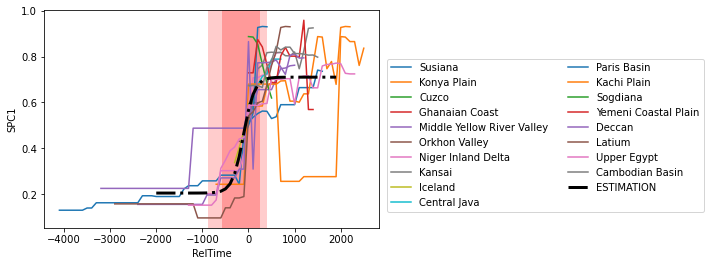

In [55]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
#plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()

In [56]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")

In [57]:
Cutout_DF[Cutout_DF["NGA"] == "Yemeni Coastal Plain"]


,NGA,RelTime,SPC1
413,Yemeni Coastal Plain,0,0.729010
414,Yemeni Coastal Plain,100,0.729010
415,Yemeni Coastal Plain,200,0.874002
416,Yemeni Coastal Plain,300,0.841906
417,Yemeni Coastal Plain,500,0.686559
418,Yemeni Coastal Plain,600,0.686559
419,Yemeni Coastal Plain,700,0.802861
420,Yemeni Coastal Plain,800,0.839822
421,Yemeni Coastal Plain,900,0.801720
422,Yemeni Coastal Plain,1000,0.801720


Cambodian Basin
166       0
167     100
168     200
169     300
170     400
171     500
172     600
173     700
174     800
175     900
176    1000
177    1100
178    1200
179    1300
180    1400
181    1500
Name: RelTime, dtype: object
Central Java
519      0
520    100
521    200
522    300
523    400
524    500
525    600
526    700
Name: RelTime, dtype: object
Cuzco
482    -100
483       0
484     100
Name: RelTime, dtype: object
Deccan
427    -2400
428    -2300
429    -2200
430    -2100
431    -2000
432    -1900
433    -1800
434    -1700
435    -1600
436    -1500
437    -1400
438    -1300
439    -1200
440    -1100
441    -1000
442     -900
443     -800
444     -700
445     -600
446     -500
447     -400
448     -300
449     -200
450     -100
451        0
452      100
453      200
454      300
455      400
456      500
457      600
458      800
459      900
460     1000
461     1100
462     1200
Name: RelTime, dtype: object
Ghanaian Coast
353    0
Name: RelTime, dtype: object
Icela

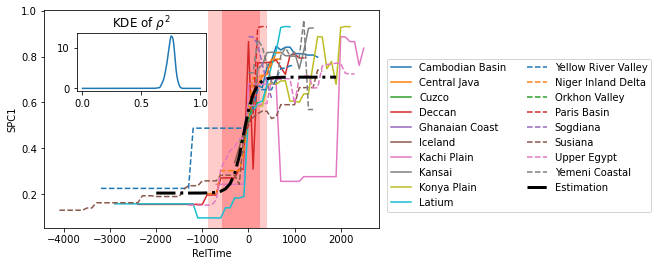

In [60]:
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
style ="-"

for N in sorted(list(set(Cutout_DF["NGA"]))):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]

      # some abbreviations
    if N=="Middle Yellow River Valley":
        name = "Yellow River Valley"
    elif N == "Yemeni Coastal Plain":
        name = "Yemeni Coastal"
    else:
        name = N
        
    print(N)
    print(DF["RelTime"])
    ax1.plot(DF["RelTime"],   
             DF["SPC1"], style,label=name)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    if N == "Latium":
        style = "--"
    
ax1.plot(TimeRange, New_Fit, "-.",label="Estimation", c = "k", linewidth=3)
lgd = ax1.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
ax1.set_ylabel("SPC1")
ax1.set_xlabel("RelTime")
ax1.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
ax1.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
ax1.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

ax2.plot(np.arange(0.0,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.0,1,0.001)))
ax2.set_title(r'KDE of $\rho^2$')

plt.savefig("Cutout_Logistic_Times_Inset.pdf",bbox_extra_artists=(lgd,),dpi=300,bbox_inches='tight')
plt.show()

In [59]:
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)), 
      "years. The interval's start and end times are", np.round(T1_scaled), "and", np.round(T2_scaled),
      "The lower boundary's uncertainty is", np.round(T1_start_scaled), "and the upper boundary's uncertainty is", 
     np.round(T2_end_scaled), "years. Thus, the upper estimate for the time range is", np.round(T2_end_scaled-T1_start_scaled), "years.")

Most of the cultural evolution takes place in a time interval of  823.0 years. The interval's start and end times are -574.0 and 249.0 The lower boundary's uncertainty is -874.0 and the upper boundary's uncertainty is 405.0 years. Thus, the upper estimate for the time range is 1279.0 years.
